## 3rd variant
### Dynamic Bayesian Network Structure Learning with quantum circuit structure learning.
This is a toy example with dummy generated training data of 4 variables, that means 8 vertices (4 for t and 4 for t+1).    
n_qubits=2 * ceil(log2(2 * nnodes)) -> for nnodes = 4, n_qubits = 6    
where first three digits correspond to vertice where the edge begins and three las digits correspond to vertice qhere edge ends i.e. 010101 corresponds to: vertice_2 ---> vertice_5  

It was tested with one generated test dataset at the end of the notebook.


In [1]:
import pandas as pd
from torch.utils.data import Dataset
import torch
import torchvision
from torch import nn
from pennylane import numpy as np
import pennylane as qml
import random
import networkx as nx
from matplotlib import pyplot as plt

In [2]:
scale = np.frompyfunc(lambda x, min, max: (x-min)/(max - min), 3, 1)

def get_edges(n=4):
    num_edges = random.randint(n, n+3)
    e1 = [(random.randint(0, n-1),random.randint(0, (n*2)-1)) for f in range(num_edges//2)]
    e2 = [(random.randint(0, (n*2)-1),random.randint(n, (n*2)-1)) for f in range(num_edges//2)]
    return e1 + e2

def get_t0(edges, weights, n=4):
    t0 = np.zeros(n) + 0.01
    edges0 = [edge for i in range(n) for edge in edges if edge[0] == i and edge[1] < n]
    if len(edges0) > 0:
        t0[edges0[0][0]] = random.random()
        for edge in edges0:
            t0[edge[1]] += weights[edge[0]] + weights[edge[1]] * t0[edge[0]]
    return t0
        
def get_t1(edges, weights, t0, n=4):
    t1 = np.zeros(n) + 0.01
    edges1 = [edge for edge in edges if edge[1] >= n]
    for edge in edges1:
        if edge[0] < n:
            t1[edge[1]-n] += weights[edge[0]] + weights[edge[1]-n] * t0[edge[0]]
        else:
            t1[edge[1]-n] += weights[edge[0]-n] + weights[edge[1]-n] * t1[edge[0]-n]
    return t1

In [3]:
# generate training dataset
exper = 1000
nnodes = 4
n_qubits = 6
arr_list = []
edges_list = []
for f in range(exper):
    weights = [random.randint(1, 10)/10 for f in range(nnodes)]
    edges = get_edges(n = nnodes)
    t0 = get_t0(edges, weights, n = nnodes)
    t1 = get_t1(edges, weights, t0, n = nnodes)
    arr_list.append(scale(np.stack([t0,t1]),np.min(np.stack([t0,t1])), np.max(np.stack([t0,t1]))).astype(float))
    edges_list.append(edges)
arr = np.concatenate(arr_list, axis=1)

In [4]:
dsa = pd.DataFrame({'t01':arr_list})
dsa

,t01
0,"[[0.0, 0.4918107303650108, 0.0, 0.015870439893..."
1,"[[0.6530668410487892, 0.0, 0.0, 0.0], [0.10017..."
2,"[[0.0, 0.0, 0.11451677576859155, 0.0], [1.0, 0..."
3,"[[0.4408631196555192, 0.0, 0.09567690178056464..."
4,"[[0.09718385475435809, 0.0, 0.0, 1.0], [0.7419..."
...,...
995,"[[0.0, 0.8347924466586949, 0.0, 0.0], [0.0, 0...."
996,"[[0.0, 0.0, 1.0, 0.0], [0.478387121911663, 0.4..."
997,"[[0.44014684789500685, 0.5933711821820098, 0.5..."
998,"[[0.0, 0.4609473269513282, 0.11420056457962102..."


In [5]:
#int("110100010",2) = 418
edges_bin_list = [[np.binary_repr(ed[0], width=n_qubits//2) + np.binary_repr(ed[1], width=n_qubits//2)  for ed in edges] for edges in edges_list]
ya_list = [[int(edge,2) for edge in edges] for edges in edges_bin_list]

In [6]:
dsa['y'] = ya_list

In [7]:
dsa

,t01,y
0,"[[0.0, 0.4918107303650108, 0.0, 0.015870439893...","[14, 25, 60, 28]"
1,"[[0.6530668410487892, 0.0, 0.0, 0.0], [0.10017...","[0, 29, 5, 28]"
2,"[[0.0, 0.0, 0.11451677576859155, 0.0], [1.0, 0...","[4, 18, 5, 7, 60, 60]"
3,"[[0.4408631196555192, 0.0, 0.09567690178056464...","[16, 24, 19, 6, 22, 22]"
4,"[[0.09718385475435809, 0.0, 0.0, 1.0], [0.7419...","[3, 11, 7, 36]"
...,...,...
995,"[[0.0, 0.8347924466586949, 0.0, 0.0], [0.0, 0....","[23, 9, 38, 39]"
996,"[[0.0, 0.0, 1.0, 0.0], [0.478387121911663, 0.4...","[18, 26, 37, 60]"
997,"[[0.44014684789500685, 0.5933711821820098, 0.5...","[1, 3, 2, 22, 53, 15]"
998,"[[0.0, 0.4609473269513282, 0.11420056457962102...","[13, 17, 22, 21, 15, 38]"


In [8]:
dev = qml.device("default.qubit", wires=n_qubits)

def RGen(param, generator, wires):
    if generator == "X":
        qml.RX(param, wires=wires)
    elif generator == "Y":
        qml.RY(param, wires=wires)
    elif generator == "Z":
        qml.RZ(param, wires=wires)


def ansatz_rsel(params, generators, wires):
    for i in range(wires):
        RGen(params[i], generators[i], wires=i)
    for i in range(wires-1):
        qml.CNOT(wires=[i,i+1])
    qml.CNOT(wires=[wires-1,0])

@qml.qnode(dev)
def qnode(inputs, weights, generators):
    for i in range(nnodes):
        qml.Rot(inputs[0,i], inputs[1,i], inputs[1,i]-inputs[0,i], wires=i)
    for j in range(n_layers):
        ansatz_rsel(weights[j*n_qubits:(j+1)*n_qubits], generators[j*n_qubits:(j+1)*n_qubits], n_qubits)
    return qml.probs(wires=range(n_qubits))

In [9]:
def cost_rsel(params, generators, inputs, y):
    probs = qnode(inputs, params, generators)
    return np.mean((probs - np.array(y, requires_grad=False))**2)

In [10]:
def error(predictions, y):
    error = np.sum(abs(y.detach().numpy() - predictions))/len(y[0].detach().numpy())
    return error

In [11]:
def get_ranks(outputs, y, weighted = False):
    rp = np.flip(np.argsort(outputs))
    if weighted:
        a = [np.argwhere(rp == x)[0][0]*outputs[x]*len(np.nonzero(y.detach().numpy())[1]) for x in np.nonzero(y.detach().numpy())[1]]
    else:
        a = [np.argwhere(rp == x)[0][0] for x in np.nonzero(y.detach().numpy())[1]]
    return a

def score(outputs, y, weighted = False):
    ly = len(np.nonzero(y.detach().numpy())[1])
    lo = len(y[0].detach().numpy())
    ranks = get_ranks(outputs, y, weighted)
    sr = sum(ranks)
    sy = sum(range(ly))
    sw = sum(range(lo-ly,lo))
    return 1 - (sr - sy)/(sw - sy) 

In [12]:
class CustomDataset(Dataset):
    def __init__(self, ds, n, q, transform=None):
        self.ds_full = ds
        self.n = n
        self.q = q
        self.x_csv = self.ds_full[["t01"]]
        self.y_csv = self.ds_full[["y"]]
        self.transform = transform

    def __len__(self):
        return len(self.x_csv)

    def __getitem__(self, idx):
        x = np.array(self.x_csv.iloc[idx].tolist())
        y = np.zeros(2**self.q)
        for i in self.y_csv.iloc[idx].tolist():
            #011000 24
            y[i] = 1/len(self.y_csv.iloc[idx].tolist()[0])
        if self.transform:
            x = self.transform(x)
            y = self.transform(y)
        return x, y

In [13]:
batch_size = 1
transform = torchvision.transforms.Lambda(lambda y: torch.from_numpy(y).float())

train_dataset = CustomDataset(dsa, nnodes, n_qubits, transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False
)

In [14]:
opt = qml.optimize.RotoselectOptimizer()
epochs=1
n_layers = 2
costs_rsel = []
rng = np.random.default_rng(seed=432852)
params_rsel = rng.random(size=n_layers * n_qubits, requires_grad=False) - 0.5
generators = np.random.choice(["X", "Y", "Z"], n_layers * n_qubits, requires_grad=False)
n_steps = 30

In [15]:
%%time
cost_rotosel = []
for epoch in range(epochs):
    loss = 0
    err = 0
    metr = 0
    wmetr = 0
    for batch_features, y_batch in train_loader:
        cost_rotosel.append(cost_rsel(params_rsel, generators, batch_features[0][0], y_batch[0]))
        kwargs = {'inputs': np.array(batch_features[0][0]), 'y': np.array(y_batch[0])}
        params_rsel, generators = opt.step(cost_rsel, params_rsel, generators, **kwargs)
        outputs = qnode(batch_features[0][0], params_rsel, generators)
        loss += cost_rotosel[-1]
    
        err += error(outputs, y_batch)

        metr += score(outputs, y_batch, False)

        wmetr += score(outputs, y_batch, True)

    loss = loss / len(train_loader)

    
    err = err / len(train_loader)
    
    metr = metr / len(train_loader)

    wmetr = wmetr / len(train_loader)

    print("epoch : {}/{}, loss = {:.6f}, error = {:.6f}, score = {:.6f}, weighted_score = {:.6f}".format(epoch + 1, 
                                                                                                        epochs, 
                                                                                                        loss, 
                                                                                                        err, 
                                                                                                        metr,
                                                                                                        wmetr))

/home/common_user/.local/lib/python3.8/site-packages/pennylane/math/multi_dispatch.py:65: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


epoch : 1/1, loss = 0.009943, error = 0.029505, score = 0.511247, weighted_score = 1.031049
CPU times: user 21min 43s, sys: 1.2 s, total: 21min 44s
Wall time: 20min 20s


In [20]:
outputs

tensor([9.99125339e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.24900614e-12, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.24900614e-12, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.05958931e-08,
        5.62101633e-09, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.99756715e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.02437544e-11, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.62101633e-09,
        8.99587504e-08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.26491835e-12, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.49785487e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.99587504e-08,
        5.06102273e-16, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.24836916e-04, 0.00000000e+00, 0.000000

In [22]:
np.flip(np.argsort(outputs))

tensor([ 0, 21, 53, 58, 42, 47, 32, 15, 63, 31, 16, 26, 10,  5, 37, 48,
         2, 61, 24, 23, 22, 60, 20, 19, 18, 17,  1, 14,  3, 13, 25, 11,
         9,  8,  7,  6,  4, 12, 54, 55, 41, 52, 51, 50, 49, 56, 46, 45,
        44, 43, 57, 40, 28, 39, 38, 36, 35, 34, 33, 59, 62, 30, 29, 27], requires_grad=True)

## testing

In [16]:
# generate Testing dataset
exper = 12
nnodes = 4
n_qubits = 6
arr_list = []
edges_list = []
edges = get_edges(n = nnodes)
for f in range(exper):
    weights = [random.randint(1, 10)/10 for f in range(nnodes)]
    t0 = get_t0(edges, weights, n = nnodes)
    t1 = get_t1(edges, weights, t0, n = nnodes)
    arr_list.append(scale(np.stack([t0,t1]),np.min(np.stack([t0,t1])), np.max(np.stack([t0,t1]))).astype(float))
    edges_list.append(edges)
arr = np.concatenate(arr_list, axis=1)

In [17]:
dstest = pd.DataFrame({'t01':arr_list})
dstest

,t01
0,"[[0.3373524868969766, 0.0, 0.06058042583869873..."
1,"[[0.2633147670576943, 0.0, 0.04550961372786775..."
2,"[[0.1617743199544939, 3.315339345270591e-05, 0..."
3,"[[0.1850549905919513, 0.0, 0.02662294835370891..."
4,"[[0.5817171226679637, 0.0, 0.3328668371291173,..."
5,"[[0.26948429186978673, 0.0, 0.0369542053619910..."
6,"[[0.24962488173950093, 0.0, 0.2069949581558156..."
7,"[[0.6699320676382194, 0.0, 0.14497896547298772..."
8,"[[0.1394210495131069, 0.0, 0.10686103468614898..."
9,"[[0.10548149444892313, 0.0, 0.0925739356318571..."


In [18]:
#int("110100010",2) = 418
edges_bin_list = [[np.binary_repr(ed[0], width=n_qubits//2) + np.binary_repr(ed[1], width=n_qubits//2)  for ed in edges] for edges in edges_list]
ya_list = [[int(edge,2) for edge in edges] for edges in edges_bin_list]

In [19]:
dstest['y'] = ya_list
dstest

,t01,y
0,"[[0.3373524868969766, 0.0, 0.06058042583869873...","[21, 16, 23, 60, 7, 63]"
1,"[[0.2633147670576943, 0.0, 0.04550961372786775...","[21, 16, 23, 60, 7, 63]"
2,"[[0.1617743199544939, 3.315339345270591e-05, 0...","[21, 16, 23, 60, 7, 63]"
3,"[[0.1850549905919513, 0.0, 0.02662294835370891...","[21, 16, 23, 60, 7, 63]"
4,"[[0.5817171226679637, 0.0, 0.3328668371291173,...","[21, 16, 23, 60, 7, 63]"
5,"[[0.26948429186978673, 0.0, 0.0369542053619910...","[21, 16, 23, 60, 7, 63]"
6,"[[0.24962488173950093, 0.0, 0.2069949581558156...","[21, 16, 23, 60, 7, 63]"
7,"[[0.6699320676382194, 0.0, 0.14497896547298772...","[21, 16, 23, 60, 7, 63]"
8,"[[0.1394210495131069, 0.0, 0.10686103468614898...","[21, 16, 23, 60, 7, 63]"
9,"[[0.10548149444892313, 0.0, 0.0925739356318571...","[21, 16, 23, 60, 7, 63]"


In [20]:
batch_size = 1
transform = torchvision.transforms.Lambda(lambda y: torch.from_numpy(y).float())

test_dataset = CustomDataset(dstest, nnodes, n_qubits, transform)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True
)


In [21]:
experiments = []
outputs_list = []
for batch_features, _ in test_loader:
    outputs = qnode(batch_features[0][0], params_rsel, generators)
    outputs_list.append(outputs)
    experiments.append(np.flip(np.argsort(outputs)))
experiments

[tensor([ 0, 58, 31, 42, 35, 37, 53, 16, 25, 29, 15, 39, 60,  9,  6, 22,
          2, 51, 55, 62, 44, 56, 40, 13,  4, 18, 33, 20, 27, 11, 46, 49,
          1, 17, 19,  7, 14,  3, 12,  5,  8, 10, 30, 21, 43, 61, 57, 54,
         52, 50, 48, 47, 45, 41, 23, 38, 36, 34, 32, 59, 28, 26, 24, 63], requires_grad=True),
 tensor([ 0, 58, 31, 35, 53, 37, 42, 25, 15, 29, 16, 39, 60, 22,  6,  9,
          2, 44, 62, 51, 40, 56, 55,  4, 18, 13, 33, 11, 27, 20, 49, 46,
          1, 17, 19,  3, 14, 12,  5,  8,  7, 10, 30, 21, 43, 61, 57, 54,
         52, 50, 48, 47, 45, 41, 23, 38, 36, 34, 32, 59, 28, 26, 24, 63], requires_grad=True),
 tensor([ 0, 58, 31, 35, 53, 37, 25, 15, 42, 29, 16, 39, 60, 22,  6,  2,
         44,  9, 62, 40, 56, 51,  4, 18, 55, 13, 33, 11, 27, 49, 20, 46,
         21, 47, 10, 54, 32, 48, 12, 26, 63,  8,  5, 50, 41,  3, 19, 23,
         57, 28, 43, 61, 45, 38, 17,  7, 34, 24, 52, 30, 14, 36,  1, 59], requires_grad=True),
 tensor([ 0, 58, 31, 35, 53, 37, 42, 25, 15, 29, 16, 39, 6

In [22]:
ol = outputs_list

In [23]:
results_list = np.mean(np.array(ol), axis=0)
norm_results_list = [float(f) for f in scale(results_list, np.min(results_list), np.max(results_list)).astype(float)]
results = [int(f) for f in np.flip(np.argsort(results_list))]

In [24]:
np.max(sum(outputs_list)),np.min(sum(outputs_list))

(tensor(7.9493692, requires_grad=True),
 tensor(9.49482953e-17, requires_grad=True))

In [25]:
results_bin = [np.binary_repr(f, width=n_qubits) for f in results]

In [26]:
results_weights = [norm_results_list[results[i]] for i in range(len(results))]

In [27]:
results[:12], ya_list[0]

([0, 58, 31, 42, 35, 53, 37, 16, 25, 29, 15, 39], [21, 16, 23, 60, 7, 63])

In [28]:
results_bin[:12]

['000000',
 '111010',
 '011111',
 '101010',
 '100011',
 '110101',
 '100101',
 '010000',
 '011001',
 '011101',
 '001111',
 '100111']

In [33]:
#number of parameters
sum([np.prod(params_rsel.shape), np.prod(generators.shape)])

24

In [30]:
def get_edges_array(n_qubits,y):
    arr = [np.binary_repr(f, width=n_qubits) for f in y]
    return [(int(f[:n_qubits//2],2), int(f[n_qubits//2:],2)) for f in arr]

In [31]:
y_edges = get_edges_array(n_qubits,ya_list[0]) 
p_edges = get_edges_array(n_qubits,results[:12]) 
p_weights = results_weights[:12]

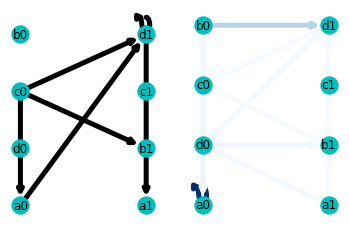

In [32]:
graph_y = None
graph_p = None

graph_y = nx.DiGraph()
graph_p = nx.DiGraph()

graph_y.add_nodes_from(range(nnodes*2))
graph_p.add_nodes_from(range(nnodes*2))

graph_y.add_edges_from(y_edges)
graph_p.add_edges_from(p_edges)

mapping = {0: "a0", 1: "b0", 2: "c0", 3: "d0", 4: "a1", 5: "b1", 6: "c1", 7: "d1"}

graph_y = nx.relabel_nodes(graph_y, mapping, copy=False)
graph_p = nx.relabel_nodes(graph_p, mapping, copy=False)

#pos = nx.shell_layout(graph_y, nlist=[range(nnodes),range(nnodes,nnodes*2)], rotate=0.1, center=(1,5))
pos = nx.bipartite_layout(graph_y, nodes=['a0','b0','c0','d0'])

subax1 = plt.subplot(121)
nx.draw(graph_y, pos, node_color='c', edge_color='k', width=5.0, edge_cmap=plt.cm.Blues, with_labels=True)

subax2 = plt.subplot(122)
nx.draw(graph_p, pos, node_color='c', edge_color=p_weights, width=5.0, edge_cmap=plt.cm.Blues, with_labels=True)
plt.show()